In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras
from pprint import pprint
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
#from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda

In [7]:
path = 'https://raw.githubusercontent.com/JohnTan38/Recommender/main/dat/'
mnames = ['movie_id','title','genres']
movies = pd.read_table(path+"movies.dat.txt", sep='::', header=None,names=mnames,engine='python', encoding='latin-1')

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table(path+"ratings.dat", sep='::', header=None, names=rnames,engine='python')

unames = ['user_id','gender','age','occ','zipcode']
users = pd.read_table(path+"users.dat.txt",sep='::', header=None, names=unames,engine='python')

#path_dir = (r'https://raw.githubusercontent.com/JohnTan38/Recommender/main/dat/')
#users = pd.read_csv(path_dir + 'users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
#https://github.com/rposhala/Recommender-System-on-MovieLens-dataset/blob/main/Recommender_System_using_Softmax_DNN.ipynb

In [10]:
merged_dataset = pd.merge(ratings, movies, how='inner', on='movie_id')
#merged_dataset.head()

refined_dataset = merged_dataset.groupby(by=['user_id','title'], as_index=False).agg({"rating":"mean"})
refined_dataset.head()

,user_id,title,rating
0,1,Airplane! (1980),4.0
1,1,Aladdin (1992),4.0
2,1,Antz (1998),4.0
3,1,Apollo 13 (1995),5.0
4,1,Awakenings (1990),5.0


In [11]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user_id'].values)
n_users = refined_dataset['user'].nunique()

item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['title'].values)
n_movies = refined_dataset['movie'].nunique()

refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(6040, 3706, 1.0, 5.0)

In [12]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((900188, 2), (100021, 2), (900188,), (100021,))

In [13]:
n_factors = 150 #Defining number of factors to be considered by embedding layer

In [14]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

X_train, X_train_array, X_train_array[0].shape

(array([[4343, 1154],
        [5184, 1007],
        [1604, 3342],
        ...,
        [1448,   12],
        [ 689, 3293],
        [5625, 2743]], dtype=int64),
 [array([4343, 5184, 1604, ..., 1448,  689, 5625], dtype=int64),
  array([1154, 1007, 3342, ...,   12, 3293, 2743], dtype=int64)],
 (900188,))

In [15]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating) #Normalizing the labels

In [16]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.embeddings.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.embeddings.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

In [17]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=30, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/70
7033/7033 [==============================] - 77s 11ms/step - loss: 0.5646 - accuracy: 0.0562 - val_loss: 0.5351 - val_accuracy: 0.0559 - lr: 0.0100
Epoch 2/70
7033/7033 [==============================] - 78s 11ms/step - loss: 0.5300 - accuracy: 0.0562 - val_loss: 0.5172 - val_accuracy: 0.0559 - lr: 0.0100
Epoch 3/70
7033/7033 [==============================] - 80s 11ms/step - loss: 0.4965 - accuracy: 0.0742 - val_loss: 0.4725 - val_accuracy: 0.1000 - lr: 0.0100
Epoch 4/70
7033/7033 [==============================] - 80s 11ms/step - loss: 0.4632 - accuracy: 0.1009 - val_loss: 0.4464 - val_accuracy: 0.1060 - lr: 0.0100
Epoch 5/70
7033/7033 [==============================] - 80s 11ms/step - loss: 0.4447 - accuracy: 0.1149 - val_loss: 0.4354 - val_accuracy: 0.1263 - lr: 0.0100
Epoch 6/70
7033/7033 [==============================] - 83s 12ms/step - loss: 0.4359 - accuracy: 0.1218 - val_loss: 0.4321 - val_accuracy: 0.1126 - lr: 0.0100
Epoch 7/70
7033/7033 [========================

Epoch 46/70
7033/7033 [==============================] - 79s 11ms/step - loss: 0.4013 - accuracy: 0.1363 - val_loss: 0.4208 - val_accuracy: 0.1325 - lr: 0.0013
Epoch 47/70
7033/7033 [==============================] - 81s 12ms/step - loss: 0.4012 - accuracy: 0.1362 - val_loss: 0.4207 - val_accuracy: 0.1296 - lr: 0.0013
Epoch 48/70
7029/7033 [============================>.] - ETA: 0s - loss: 0.4010 - accuracy: 0.1362
Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0010011291014961898.
7033/7033 [==============================] - 79s 11ms/step - loss: 0.4010 - accuracy: 0.1362 - val_loss: 0.4211 - val_accuracy: 0.1310 - lr: 0.0013
Epoch 49/70
7033/7033 [==============================] - 79s 11ms/step - loss: 0.4009 - accuracy: 0.1363 - val_loss: 0.4210 - val_accuracy: 0.1313 - lr: 0.0010
Epoch 50/70
7033/7033 [==============================] - 80s 11ms/step - loss: 0.4009 - accuracy: 0.1365 - val_loss: 0.4207 - val_accuracy: 0.1336 - lr: 0.0010
Epoch 51/70
7030/7033 [=============

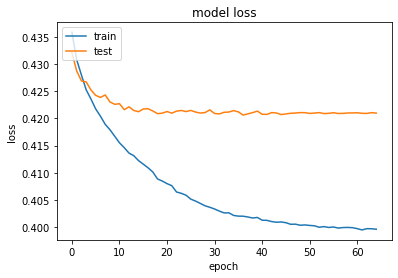

In [18]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
refined_dataset.head()

In [19]:
'''
How DNN model works is, it takes two inputs, one of the input has user id's and the other has corresponding movie id's. 
Here DNN model tries to predict the ratings of the user - movie combination. 
So, we can input a specific user id (broadcasting it with the size of other input) and unseen movie id of the user and expect 
the model to give the ratings of the movies which would have been the ratings given by the user. 
Here, the ratings are already normalized and as we need the movies which interest the user more, 
ratings are not brought back to 0-5 scale.
'''

X_train_array

[array([4343, 5184, 1604, ..., 1448,  689, 5625], dtype=int64),
 array([1154, 1007, 3342, ...,   12, 3293, 2743], dtype=int64)]

In [21]:
user_id = [2696] #movies seen by user_id
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['user_id'] == user_id[0]]['movie'])
print(seen_movies)

[258, 294, 707, 765, 921, 1007, 1290, 1628, 1637, 1724, 1860, 1869, 1973, 2164, 2503, 2548, 2677, 2979, 3257, 3630]


In [22]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

(3706, 0, 3705)

In [23]:
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies) #exclude 'seen movies'

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [24]:
len(unseen_movies) + len(seen_movies)

3706

In [25]:
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])

(2, 3686)

In [26]:
predicted_ratings = model.predict(model_input) #DNN model used to predict the ratings of 'unseen movies'

In [ ]:
print(predicted_ratings.shape)
print(predicted_ratings)

In [27]:
predicted_ratings = np.max(predicted_ratings, axis=1)
#predicted_ratings.shape
predicted_ratings

array([0.99225414, 0.964602  , 0.99452716, ..., 0.9680973 , 0.9870323 ,
       0.9583303 ], dtype=float32)

In [28]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

[3096 2452 1788 ... 3362 3653  970]


In [29]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies

array(['Sour Grapes (1998)', "One Flew Over the Cuckoo's Nest (1975)",
       "Jupiter's Wife (1994)", ...,
       'Time Regained (Le Temps Retrouvé) (1999)',
       'Withnail and I (1987)', 'Down Periscope (1996)'], dtype=object)

In [30]:
from pprint import pprint #recommended movies with Softmax DNN
pprint(list(recommended_movies[:20]))

['Sour Grapes (1998)',
 "One Flew Over the Cuckoo's Nest (1975)",
 "Jupiter's Wife (1994)",
 'Ripe (1996)',
 'Never Been Kissed (1999)',
 'Misérables, Les (1998)',
 'Steal This Movie! (2000)',
 'Alligator (1980)',
 'Strangeland (1998)',
 'Soul Food (1997)',
 'Problem Child 2 (1991)',
 'Interiors (1978)',
 'Star Trek: The Wrath of Khan (1982)',
 'Stop! Or My Mom Will Shoot (1992)',
 'History of the World: Part I (1981)',
 'Home Alone (1990)',
 'Blair Witch Project, The (1999)',
 'Five Senses, The (1999)',
 'Promise, The (La Promesse) (1996)',
 'Home Alone 3 (1997)']


In [35]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user_id'] == user_id]['title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user_id'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

In [36]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)

Enter user id
888
Enter number of movies to be recommended:
10

Movie seen by the User:
['101 Dalmatians (1961)',
 'Ace Ventura: Pet Detective (1994)',
 'Ace Ventura: When Nature Calls (1995)',
 'Air Force One (1997)',
 'Aladdin and the King of Thieves (1996)',
 'American Beauty (1999)',
 'American Tail: Fievel Goes West, An (1991)',
 'Anastasia (1997)',
 'As Good As It Gets (1997)',
 'Back to the Future (1985)',
 'Beauty and the Beast (1991)',
 'Being John Malkovich (1999)',
 'Birdcage, The (1996)',
 'Brady Bunch Movie, The (1995)',
 'Braveheart (1995)',
 "Bug's Life, A (1998)",
 'Clueless (1995)',
 'Con Air (1997)',
 'Dragonheart (1996)',
 'Face/Off (1997)',
 'Forrest Gump (1994)',
 'Frequency (2000)',
 'Full Monty, The (1997)',
 'Glory (1989)',
 'GoldenEye (1995)',
 'Gremlins (1984)',
 'Independence Day (ID4) (1996)',
 'Indiana Jones and the Last Crusade (1989)',
 "Jackie Chan's First Strike (1996)",
 'Jurassic Park (1993)',
 'Kid, The (2000)',
 'Lake Placid (1999)',
 'Life Is Beaut